In [392]:
# import test_tensor_2d as tt ttbd
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import denseQubits as dq
import hubbardJWT as hjw
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product
import denseSpinhalf
import autoray
import scipy.sparse as sparse


In [394]:
reload(dq)
sql = dq.SpinlessDense()
# sql.t_make_stabilizers()

In [395]:
reload(dq)
reload(hjw)

##Testing params
T_PARAM=1
V_PARAM=0
MU_PARAM=0
LX, LY = 2, 3


### Analytical Hubbard Hamiltonian
hub = hjw.HubbardSpinless(Lx=LX, Ly=LY)
hub.build_spinless_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
Hexact = hub._Ham.copy()
gex, gsx = qu.eigh(Hexact)
print('Exact: {}'.format(gex[0]))

nx = hub.state_occs(state=gsx[:,0])
print(nx,end='\n\n')


### Qubit lattice Hamiltonian
sql = dq.SpinlessDense(Lx=LX,Ly=LY)
sql.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
sql.make_stabilizer()

rotHam = sql.projected_ham_3() 
Uplus = sql._Uplus
rens, reigst = qu.eigh(rotHam)
print(rens[0])

print(sql.state_local_occs(k=None, qstate=Uplus@reigst[:,0]))

Exact: -3.8284271247461907
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]

Stabilizer:
1-----2
|     |
4-----5
None None 6 None

-3.828427124746188
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]


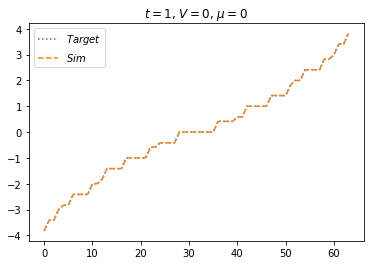

In [396]:
plt.plot(gex, ':', label=r'$Target$') #exact Hubbard energies
plt.plot(rens, '--',label=r'$Sim$')

plt.title(r'$t={}$, $V={}$, $\mu={}$'.format(T_PARAM,V_PARAM,MU_PARAM))
plt.legend()

In [397]:
for k in range(64):
    A = hub.state_occs(qu.basis_vec(i=k, dim=64))
    B = sql.state_local_occs(qstate=Uplus[:,k])
    assert np.allclose(A,B) #may not hold when degeneracies
sql.one_qubit_dm(Uplus@reigst[:,0], i=5)

[[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]

In [400]:
# reload(stab)
reload(dq)
# qlat = dq.SpinlessDense(Lx=3, Ly=3)
# Uplus = stab.two_qubit_codespace(qlat)
# Uplus.shape
# qlat = dq.SpinlessDense(Lx=4,Ly=3)
# Up3 = stab.three_qubit_stabilizer(qlat)
reload(hjw)
# reload(denseSpinhalf)

hubhalf = hjw.HubbardSpinhalfExact(Lx=1, Ly=4, t=1.0, U=0)
hubhalf.build_spinhalf_ham()
h2ex = hubhalf.HamExact()

dse = dq.DenseSpinhalf(Lx=1,Ly=4)
dse.make_simulator_ham(t=1.0, U=0)
H2 = dse.ham_sim()

np.array_equal(H2, h2ex)# np.array_equal(H2, h2ex)

True

In [401]:
reload(beeky)
reload(dq)

T_PARAM=1.0
V_PARAM=1.5
MU_PARAM=1.5

# qlat = dq.SpinlessDensee(Lx=2,Ly=3)
# qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# qenet = beeky.QubitEncodeNet(qlat)
# MyHam = beeky.SpinlessFermiSim(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# tebd = beeky.iTimeTEBD(qenet, MyHam, compute_every=50)
tebd.evolve(steps=100)



# print('Naive:',qenet.compute_energy_deprec(T_PARAM, V_PARAM, MU_PARAM))

# print('<H>:  ',qenet.compute_ham_expec(MyHam))

# qlat.make_simulator_ham(t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
# H_d = qlat.ham_sim()
# psi_d = qenet.net_to_dense()

# print('Dense:',(psi_d.H @ H_d @ psi_d)[0][0])


n=1560, tau=0.01, energy~-7.156007: 100%|██████████| 100/100 [00:02<00:00, 34.71it/s]


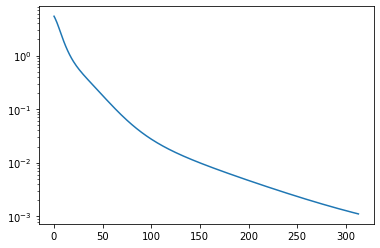

In [402]:
# tebd.energies[-10:-1]
plt.semilogy(np.array(tebd.energies) --7.15712901 )
plt.hlines(xmin=0, xmax=300, y=-7.15712901)
# print(qenet.compute_ham_expec(MyHam))
# print(tebd._check_energy())
# qenet.check_dense_energy().item()

In [209]:
Hsim = qlat.ham_sim()
print(qu.eigh(Hsim)[0][0:4])
print(sparse.linalg.eigsh(Hsim, which='SA')[0][0:4])

[-7.15712901 -7.00136161 -6.6051446  -6.35889624]
[-7.15712901 -7.00136161 -6.6051446  -6.35889624]


In [404]:
reload(beeky)
reload(dq)
T_PARAM = 1.4
U_PARAM = 0.9

newlat = dq.SpinlessDense(Lx=1, Ly=4)

newHam = beeky.SpinhalfHubbardSim(newlat, t=T_PARAM, U=U_PARAM)

newnet = beeky.QubitEncodeNet.rand_network(newlat,phys_dim=4)

tebd2 = beeky.iTimeTEBD(newnet, newHam, compute_every=20)

# dse = denseSpinhalf.DenseSpinhalfEncoder(Lx=1, Ly=4)
# dse.make_simulator_ham(t=T_PARAM, U=U_PARAM)
# Hdense = dse.ham_sim()
# ens, est = qu.eigh(Hdense)
print(ens[0:3])
# psid = newnet.net_to_dense()
# print((psid.H @ Hdense @ psid).item())


[-5.42097074 -4.97826792 -4.97826792]


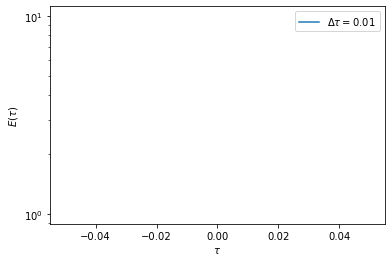

In [405]:
# tebd2.evolve(steps=60)
plt.semilogy(0.01* np.array(tebd2.iters), np.array(tebd2.energies)-ens[0] , label='$\\Delta\\tau=0.01$')
plt.xlabel('$\\tau$')
plt.ylabel('$E(\\tau)$')
plt.legend()

In [376]:
tebdstate = newnet.net_to_dense()
norm = np.sqrt(newnet.get_norm_scalar())
diff = ((tebdstate/norm) - est[:,0]).reshape(-1,1).round(3)
diff = diff.reshape(-1)
where = diff.nonzero()
diff[where]

[ 0.038+0.j -0.098+0.j  0.098+0.j ...  0.098+0.j -0.098+0.j  0.038+0.j]